# Classifying Reddit Posts by Topic: AI

## Step 1: Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tkinter as tk
from tkinter import filedialog
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from wordcloud import WordCloud

## Step 2: Import Dataset

In [34]:
os.chdir('D:\\reddit\\reddit\\code\\')

In [7]:
def select_file():
    root = tk.Tk()
    root.withdraw()
    file_path = filedialog.askopenfilename()
    return file_path

# Example usage
input_path = select_file()

# Load the data
df = pd.read_csv(input_path)

# Clean the data
df = df.dropna()

## Step 3: Split and Vectorize

In [8]:
# Stopwords for vectorizer
stopwords = [
    "all", "any", "being", "both", "each", "few", "more", "most", "myself",
    "no", "nor", "not", "off", "only", "other", "our", "ours", "ourselves",
    "own", "same", "some", "such", "too", "very", "what", "which", "who",
    "whom", "why", "yours", "yourself", "yourselves"
]

stopwords_df = pd.DataFrame(stopwords, columns=['text'])

In [9]:
# Split data into features and labels
X = df['processed_text']
Y = df['label']

# Split data into training and test sets first
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Combine training data back for resampling
train_data = pd.concat([X_train, Y_train], axis=1)

# Separate majority and minority classes
class_0 = train_data[train_data['label']==0]
class_1 = train_data[train_data['label']==1]

# Downsample majority class
class_0_downsampled = resample(class_0, 
                               replace=False,    # sample without replacement
                               n_samples=len(class_1),     # to match minority class
                               random_state=42) # reproducible results

# Combine minority class with downsampled majority class
train_data_balanced = pd.concat([class_0_downsampled, class_1])

# Splitting the features and label variable for balanced data
X_train_balanced = train_data_balanced.drop('label', axis=1)
Y_train_balanced = train_data_balanced['label']

# Now, vectorize the text data
vectorizer = CountVectorizer(ngram_range=(1, 1), max_df=0.9999, min_df=0.0001, stop_words=stopwords)

# Vectorize the balanced training features
X_train_balanced_counts = vectorizer.fit_transform(X_train_balanced.squeeze())

# Vectorize the test features
X_test_counts = vectorizer.transform(X_test)

In [10]:
# Get the number of features in the vectorizer
feature_names = vectorizer.get_feature_names_out()
num_features = len(feature_names)
print(f"Number of words (features) in the vectorizer: {num_features}")

Number of words (features) in the vectorizer: 1347


## Step 4: Train a Logistic Regression CV Classifier

In [11]:
# Train a Logistic Regression CV classifier
clf = LogisticRegressionCV(cv=5, max_iter=1000)
clf.fit(X_train_balanced_counts, Y_train_balanced)

# Predict on the test set
Y_pred = clf.predict(X_test_counts)

# Calculate accuracy
accuracy = accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.669417581274874


## Step 6: Get Top Features

In [12]:
ai_class_index = 1

# Get the coefficients of the features for the class of interest
# For binary classification, clf.coef_ will have shape (1, n_features)
# For multi-class classification, it will have shape (n_classes, n_features)
feature_coeffs = clf.coef_[0] if clf.coef_.shape[0] == 1 else clf.coef_[ai_class_index]

# Get the indices of the top N features with the highest absolute coefficients
top_n = 50
top_n_indices = np.argsort(np.abs(feature_coeffs))[-top_n:][::-1]

# Get the corresponding feature names and their scores
top_feature_names = vectorizer.get_feature_names_out()[top_n_indices]
top_feature_scores = feature_coeffs[top_n_indices]

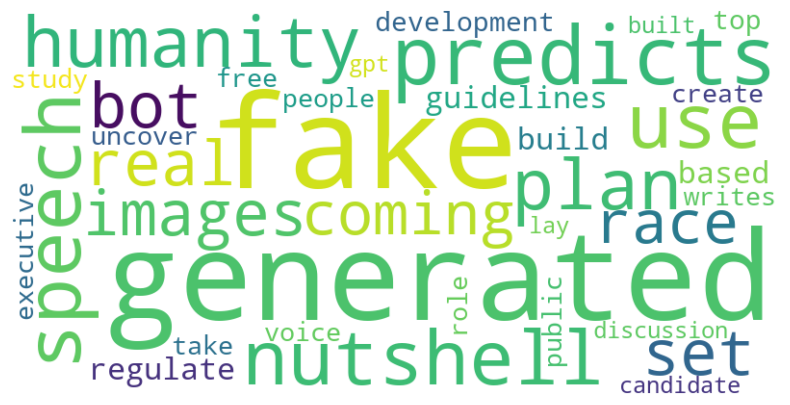

In [13]:
# Generate and display word cloud image
positive_features = {name: score for name, score in zip(top_feature_names, top_feature_scores) if score > 0} # Filter positive features and their scores
wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate_from_frequencies(positive_features)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Step 7: Get Probabilities for Each Post and Plot

In [14]:
# Ensure 'created_utc' is in datetime format
df['created_utc'] = pd.to_datetime(df['created_utc'])

# Extract the date part
df['date'] = df['created_utc'].dt.date

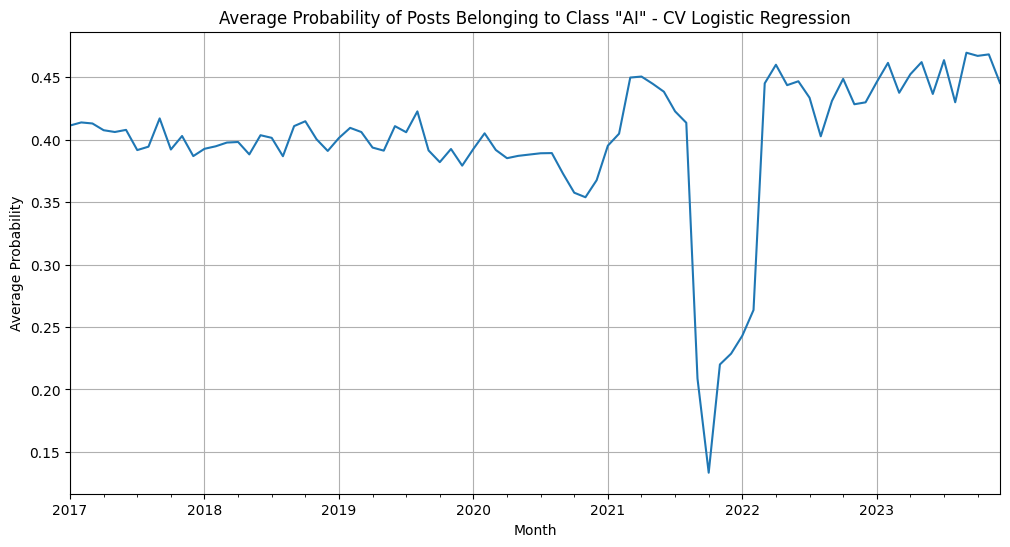

In [15]:
# Ensure 'created_utc' is in datetime format
df['created_utc'] = pd.to_datetime(df['created_utc'])

# Extract the month and year part
df['year_month'] = df['created_utc'].dt.to_period('M')

# Predict probabilities for class 1
X_counts = vectorizer.transform(df['processed_text'])  # Vectorize the entire dataset
probabilities = clf.predict_proba(X_counts)[:, 1]  # Getting the probability for class 1
df['probability'] = probabilities

# Group by year and month and calculate the monthly average probabilities
monthly_average_probabilities = df.groupby('year_month').probability.mean()

# Plot the results
plt.figure(figsize=(12, 6))
monthly_average_probabilities.plot(kind='line')
plt.title('Average Probability of Posts Belonging to Class "AI" - CV Logistic Regression')
plt.xlabel('Month')
plt.ylabel('Average Probability')
plt.grid(True)
plt.show()